# Making the Best Use of the 100M Budget

In Fantasy Premier League (FPL) we are given a starting budget of 100M. This budget must be spent on 15 players: 2 Goalkeepers (GK), 5 Defenders (DEF), 5 Midfielders (MID) and 3 Forwards (FWD). From these 15 we must have 11 starters: 1 GK, at least 3 DEF and at least one FWD. The other 4 players are benched. A maximum of 3 players can be selected from any one club.Each player is awarded/deducted points based on their real life performances.<br> 

<b>Points are awarded as follows:</b><br>
For playing up to 60 minutes: 1<br>
For playing 60 minutes or more (excluding stoppage time): 2<br>
For each goal scored by a goalkeeper or defender: 6<br>
For each goal scored by a midfielder: 5<br>
For each goal scored by a forward: 4<br>
For each goal assist: 3<br>
For a clean sheet by a goalkeeper or defender: 4<br>
For a clean sheet by a midfielder: 1<br>
For every 3 shot saves by a goalkeeper: 1<br>
For each penalty save: 5<br>
For each penalty miss: -2<br>
Bonus points for the best players in a match: 1-3<br>
For every 2 goals conceded by a goalkeeper or defender: -1<br>
For each yellow card: -1<br>
For each red card: -3<br>
For each own goal: -2<br>

We will use the data provided to deeply analyse each player in order to figure out which players are the best possible players to have in your starting team. These players will be analysed in order to fit the 100M budget perfectly. Data from the 2020/2021 season will be used.

In [2]:
import os
import math
import itertools
import re
import random
from collections import OrderedDict
from pathlib import Path
import multiprocessing as mp
from datetime import datetime
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from loguru import logger
from scipy.stats import linregress
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
sns.set(style="white")
%matplotlib inline

All data will be read in to dataframes named accordingly.

In [3]:
os.chdir('../data') 
gws_data = 'clean/20_21/gws20_21.pkl'
teams_data = 'clean/20_21/teams20_21.pkl'
fixtures_data = 'clean/20_21/fixtures20_21.pkl'
gws = pd.read_pickle(gws_data)
teams = pd.read_pickle(teams_data)
fixtures = pd.read_pickle(fixtures_data)

# Breakdown of Points by Teams

To start off, we can look at each team and the points scored overall by each team, compared to their starting values (using GW2 as starting value as 4 teams did not play in GW1)

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


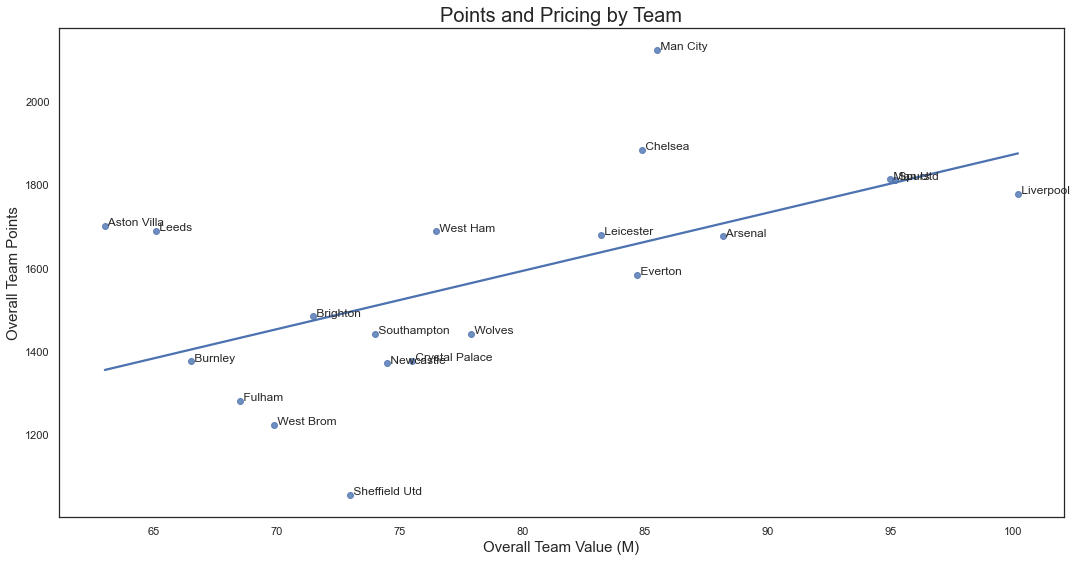

In [4]:
#Remove players that did not play all season
temp_gws = gws[gws.minutes != 0]
team_total_points = temp_gws.groupby('team')['total_points'].sum()
team_total_value = temp_gws.loc[temp_gws['gw'] == 2].groupby('team')['value'].sum()/10

teams_value_points = pd.merge(team_total_value, team_total_points, on=['team'], how='left').reset_index() 

fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
    teams_value_points['value'], teams_value_points['total_points'], ax=ax, ci=False, marker='o'
)
ax.set_title('Points and Pricing by Team', fontsize = 20)
ax.set_xlabel('Overall Team Value (M)', fontsize = 15)
ax.set_ylabel('Overall Team Points', fontsize = 15)

for i, txt in enumerate(teams_value_points['team']):
    ax.annotate(' '+ txt, (teams_value_points['value'][i], teams_value_points['total_points'][i]), fontsize = 12)

Teams above the regression line, perform better in relation to their price, while teams below the regression line perform worse in relation to price. We can see Man City players score very highly, and Aston Villa and Leeds players could potentially be excellent budget players as the perform extremely well with regards to price. Sheffield United players must be avoided. We can look further into this by splitting up teams into positions.

In [5]:
os.chdir('../figs')

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

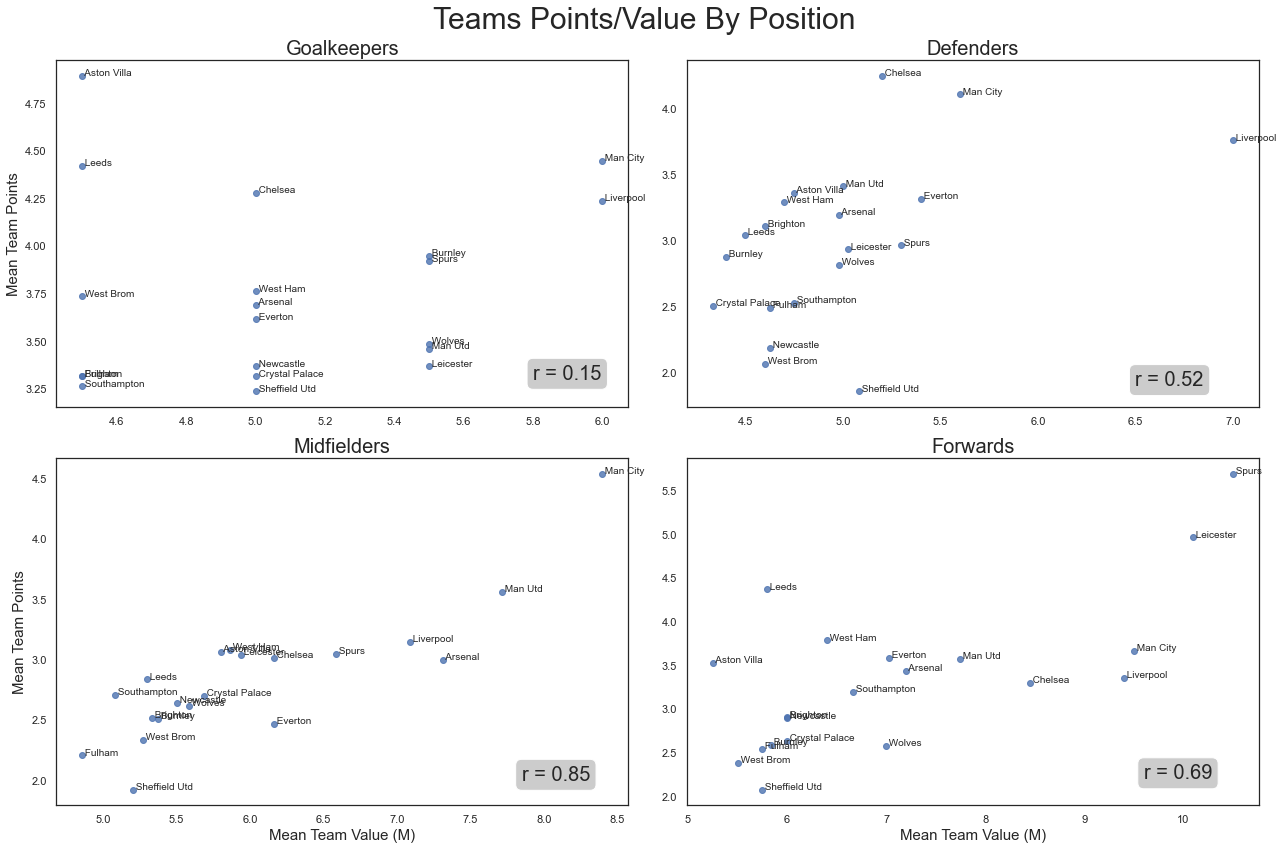

In [6]:
team_pos_value = temp_gws.loc[temp_gws['gw'] == 2].groupby(['team', 'position'])['value'].mean()/10
team_pos_points = temp_gws.groupby(['team', 'position'])['total_points'].mean()

team_pos_value_points = pd.merge(team_pos_value, team_pos_points, on=['team','position'], how='left').reset_index() 

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle('Teams Points/Value By Position', fontsize=30)

axs[0, 0].set_title('Goalkeepers', fontsize = 20)
axs[0, 1].set_title('Defenders', fontsize = 20)
axs[1, 0].set_title('Midfielders', fontsize = 20)
axs[1, 1].set_title('Forwards', fontsize = 20)

sns.regplot(
    team_pos_value_points.groupby('position').get_group('GK')['value'], 
    team_pos_value_points.groupby('position').get_group('GK')['total_points'], ax=axs[0,0], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('GK')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('GK')['value'])[0,1],2)),
           xy=(5.8,3.3), fontsize = 20, bbox = bbox)

sns.regplot(
    team_pos_value_points.groupby('position').get_group('DEF')['value'], 
    team_pos_value_points.groupby('position').get_group('DEF')['total_points'], ax=axs[0,1], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('DEF')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('DEF')['value'])[0,1],2)),
           xy=(6.5,1.9), fontsize = 20, bbox = bbox)



sns.regplot(
    team_pos_value_points.groupby('position').get_group('MID')['value'], 
    team_pos_value_points.groupby('position').get_group('MID')['total_points'], ax=axs[1,0], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('MID')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('MID')['value'])[0,1],2)),
           xy=(7.85,2), fontsize = 20, bbox = bbox)



sns.regplot(
    team_pos_value_points.groupby('position').get_group('FWD')['value'], 
    team_pos_value_points.groupby('position').get_group('FWD')['total_points'], ax=axs[1,1], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('FWD')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('FWD')['value'])[0,1],2)),
           xy=(9.6,2.2), fontsize = 20, bbox = bbox)


axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Mean Team Points', fontsize = 15)

axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')

axs[1, 0].set_xlabel('Mean Team Value (M)', fontsize = 15)
axs[1, 0].set_ylabel('Mean Team Points', fontsize = 15)

axs[1, 1].set_xlabel('Mean Team Value (M)', fontsize = 15)
axs[1, 1].set_ylabel('')

for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('GK')['team']):
    axs[0,0].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('GK')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('GK')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('DEF')['team']):
    axs[0,1].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('DEF')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('DEF')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('MID')['team']):
    axs[1,0].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('MID')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('MID')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('FWD')['team']):
    axs[1,1].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('FWD')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('FWD')['total_points'])[i]))
    
fig.tight_layout()
fig.savefig("team_points_value.png")

This figure shows that there is a strong positive correlation between value and points for midfielders and forwards, and a weak positive correlation between value and points for goalkeepers.

Fig for Report

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

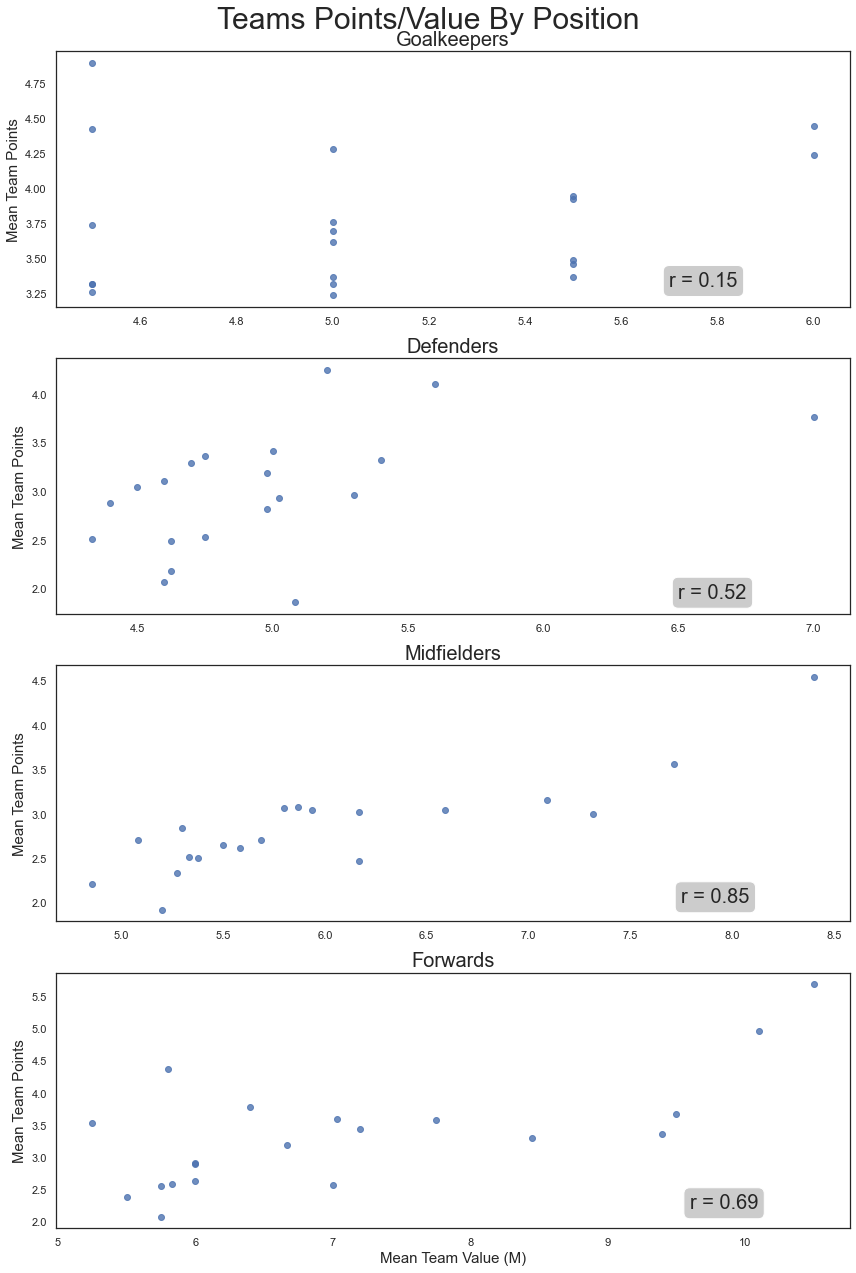

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(12, 18))
plt.suptitle('Teams Points/Value By Position', fontsize=30)

axs[0].set_title('Goalkeepers', fontsize = 20)
axs[1].set_title('Defenders', fontsize = 20)
axs[2].set_title('Midfielders', fontsize = 20)
axs[3].set_title('Forwards', fontsize = 20)

sns.regplot(
    team_pos_value_points.groupby('position').get_group('GK')['value'], 
    team_pos_value_points.groupby('position').get_group('GK')['total_points'], ax=axs[0], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('GK')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('GK')['value'])[0,1],2)),
           xy=(5.7,3.3), fontsize = 20, bbox = bbox)

sns.regplot(
    team_pos_value_points.groupby('position').get_group('DEF')['value'], 
    team_pos_value_points.groupby('position').get_group('DEF')['total_points'], ax=axs[1], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('DEF')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('DEF')['value'])[0,1],2)),
           xy=(6.5,1.9), fontsize = 20, bbox = bbox)



sns.regplot(
    team_pos_value_points.groupby('position').get_group('MID')['value'], 
    team_pos_value_points.groupby('position').get_group('MID')['total_points'], ax=axs[2], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('MID')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('MID')['value'])[0,1],2)),
           xy=(7.75,2), fontsize = 20, bbox = bbox)



sns.regplot(
    team_pos_value_points.groupby('position').get_group('FWD')['value'], 
    team_pos_value_points.groupby('position').get_group('FWD')['total_points'], ax=axs[3], ci=False, marker='o',fit_reg=False
).annotate('r = ' + str(round(np.corrcoef(team_pos_value_points.groupby('position').get_group('FWD')['total_points'],
                                        team_pos_value_points.groupby('position').get_group('FWD')['value'])[0,1],2)),
           xy=(9.6,2.2), fontsize = 20, bbox = bbox)



axs[0].set_xlabel('')
axs[0].set_ylabel('Mean Team Points', fontsize = 15)

axs[1].set_xlabel('')
axs[1].set_ylabel('Mean Team Points', fontsize = 15)

axs[2].set_xlabel('')
axs[2].set_ylabel('Mean Team Points', fontsize = 15)

axs[3].set_xlabel('Mean Team Value (M)', fontsize = 15)
axs[3].set_ylabel('Mean Team Points', fontsize = 15)

'''
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('GK')['team']):
    axs[0,0].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('GK')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('GK')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('DEF')['team']):
    axs[0,1].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('DEF')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('DEF')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('MID')['team']):
    axs[1,0].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('MID')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('MID')['total_points'])[i]))
    
for i, txt in enumerate(team_pos_value_points.groupby('position').get_group('FWD')['team']):
    axs[1,1].annotate(' '+ txt, (list(team_pos_value_points.groupby('position').get_group('FWD')['value'])[i],
                                 list(team_pos_value_points.groupby('position').get_group('FWD')['total_points'])[i]))
''' 
fig.tight_layout()
fig.savefig("team_points_value.png")

## Most Successful Positions for each Team

We will look into how many points were scored by each position for each team.

Text(0.5, 1.0, 'Mean Points Scored by Outfield Positions for each Team')

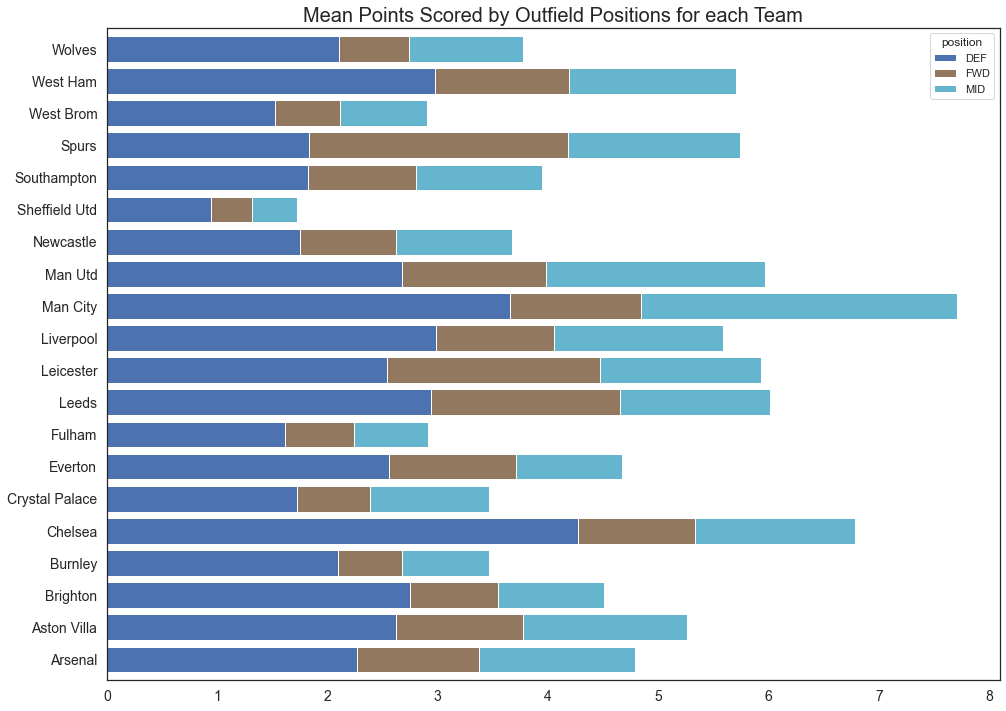

In [8]:
mean_goals = pd.DataFrame(temp_gws.groupby(['team', 'position'])['goals_scored'].mean()).reset_index()

#generate mean points scored from goals
mean_goals.loc[mean_goals['position'] == 'GK', 'goals_scored'] = mean_goals['goals_scored']*6
mean_goals.loc[mean_goals['position'] == 'DEF', 'goals_scored'] = mean_goals['goals_scored']*6
mean_goals.loc[mean_goals['position'] == 'MID', 'goals_scored'] = mean_goals['goals_scored']*5
mean_goals.loc[mean_goals['position'] == 'DEF', 'goals_scored'] = mean_goals['goals_scored']*4

#generate mean points scored from assists
mean_assists = pd.DataFrame(temp_gws.groupby(['team', 'position'])['assists'].mean()*3).reset_index()

#generate mean points scored from bonus points
mean_bonus = pd.DataFrame(temp_gws.groupby(['team', 'position'])['bonus'].mean()).reset_index()

#generate mean points scored from clean_sheets
mean_clean_sheets = pd.DataFrame(temp_gws.groupby(['team', 'position'])['clean_sheets'].mean()).reset_index()
mean_clean_sheets.loc[mean_clean_sheets['position'] == 'GK', 'clean_sheets'] = mean_clean_sheets['clean_sheets']*4
mean_clean_sheets.loc[mean_clean_sheets['position'] == 'DEF', 'clean_sheets'] = mean_clean_sheets['clean_sheets']*4

#generate mean points scored from saves + penalty saves
mean_saves = pd.DataFrame(temp_gws.groupby(['team', 'position'])['saves'].mean()//3).reset_index()
mean_penalty_saves = pd.DataFrame(temp_gws.groupby(['team', 'position'])['penalties_saved'].sum()*5).reset_index()

#Merge DFs
mean_points_breakdown = pd.merge(mean_goals, mean_assists, on=['team','position'], how='left')
mean_points_breakdown = pd.merge(mean_points_breakdown, mean_bonus, on=['team','position'], how='left')
mean_points_breakdown = pd.merge(mean_points_breakdown, mean_clean_sheets, on=['team','position'], how='left')
mean_points_breakdown = pd.merge(mean_points_breakdown, mean_saves, on=['team','position'], how='left')
mean_points_breakdown = pd.merge(mean_points_breakdown, mean_penalty_saves, on=['team','position'], how='left')

position_points_breakdown = mean_points_breakdown
position_points_breakdown = position_points_breakdown.set_index(['team', 'position'])
position_points_breakdown['Mean_Points'] = position_points_breakdown.sum(axis=1)
teams_position_points_breakdown = position_points_breakdown.drop(
    ['goals_scored', 'assists', 'bonus','clean_sheets','saves', 'penalties_saved'], axis=1)
teams_position_points_breakdown = teams_position_points_breakdown.unstack()
teams_position_points_breakdown = teams_position_points_breakdown['Mean_Points'].drop(['GK'], axis = 1)

teams_position_points_breakdown.plot(kind='barh',
                                     stacked=True,
                                     colormap=ListedColormap(sns.color_palette()),
                                     figsize=(16,12),
                                     xlabel= '',
                                     fontsize = 14,
                                     width=.8).set_title("Mean Points Scored by Outfield Positions for each Team", fontsize = 20)

 This could be important when it comes to picking formation as defenders+midfifelders seem to have a huge cut of the overall points. The defenders of Chelsea stand out as being must-have players due to the sheer amount of points scored by them.

### Points Scored by Positions

We will look into how each position scores the majority of their points.

Text(0.5, 1.0, 'How Outfield Positions Score Their Points')

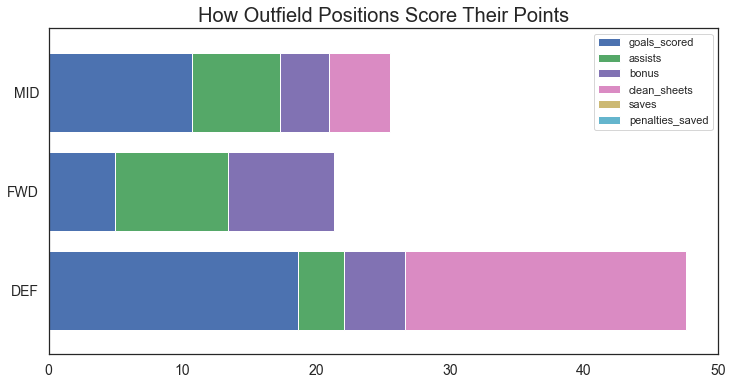

In [9]:
points_breakdown_by_position = mean_points_breakdown.groupby(['position']).sum()
points_breakdown_by_position = points_breakdown_by_position.drop(['GK'], axis = 0)
points_breakdown_by_position.plot(kind='barh',
                                  stacked=True,
                                  colormap=ListedColormap(sns.color_palette()),
                                  figsize=(12,6),
                                  xlabel= '',
                                  fontsize = 14,
                                  width=.8).set_title("How Outfield Positions Score Their Points", fontsize = 20)

Surprisingly here, we see that defenders scored roughly half their points from goals, while forwards mainly contributed through assists and bonus points. Midfielders have an even enough spread of how they score their points.

# Investigating Players

We can look into the Return on Investment (ROI) on players in order to spot players who perform well in relation to their price.

In [10]:
#Calculate ROI = Return/Cost of investment, in FPL terms ROI = Points Scored/Price
temp_gws = gws[gws.minutes != 0]
player_total_points = temp_gws.groupby('name')['total_points'].sum()

#Creates a player list and finds out the first game week they had a value in
player_list = list(gws['name'].unique())
gw_dict = {}
for i in player_list:
    x = gws.loc[gws['name'] == i]
    data = x['value'].idxmax()
    gw_dict[i] = data 
    
#Takes each player and gameweek and finds the players initial value
names_values = {}
for key in gw_dict:
    z = gws.loc[gws['gw'] == gw_dict[key]]
    names_values[key] = str(pd.DataFrame(z.loc[z['name'] == key]['value']/10).set_index('value')).split()[5].replace('[','').replace(']','').replace(',','')
names_values = pd.DataFrame.from_dict(names_values, orient='index')

player_df = names_values.reset_index()
player_df.columns = ['name', 'value']
player_df = player_df.set_index('name')

player_value_points = pd.merge(player_df,player_total_points, on=['name'], how='left')

#Adding ROI
player_value_points['value'] = pd.to_numeric(player_value_points['value'])
player_value_points['ROI'] = player_value_points['total_points']/player_value_points['value']

gw1 = gws.loc[gws['gw'] == 38]
name_pos = pd.concat([gw1['name'], gw1['position'], gw1['team']], axis=1, keys=['name', 'position', 'team'])
name_pos.reset_index()
player_value_points = pd.merge(player_value_points, name_pos, on=['name'], how='left')
player_value_points = player_value_points.set_index('name')

player_value_points = player_value_points.sort_values(by='ROI', ascending=False)
player_value_points

,value,total_points,ROI,position,team
name,,,,,
Emiliano Martínez,5.4,186.0,34.444444,GK,Aston Villa
Illan Meslier,4.8,154.0,32.083333,GK,Leeds
Stuart Dallas,5.5,171.0,31.090909,DEF,Leeds
Sam Johnstone,4.6,140.0,30.434783,GK,West Brom
Jack Harrison,5.6,160.0,28.571429,MID,Leeds
...,...,...,...,...,...
Fikayo Tomori,5.0,0.0,0.000000,DEF,Chelsea
Michael Hector,4.5,0.0,0.000000,DEF,Fulham
Neil Taylor,4.5,-1.0,-0.222222,DEF,Aston Villa


From just printing out the dataframe, we can see that the players with the highest ROI have very low prices. These players could be used to pick up some bargains.

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


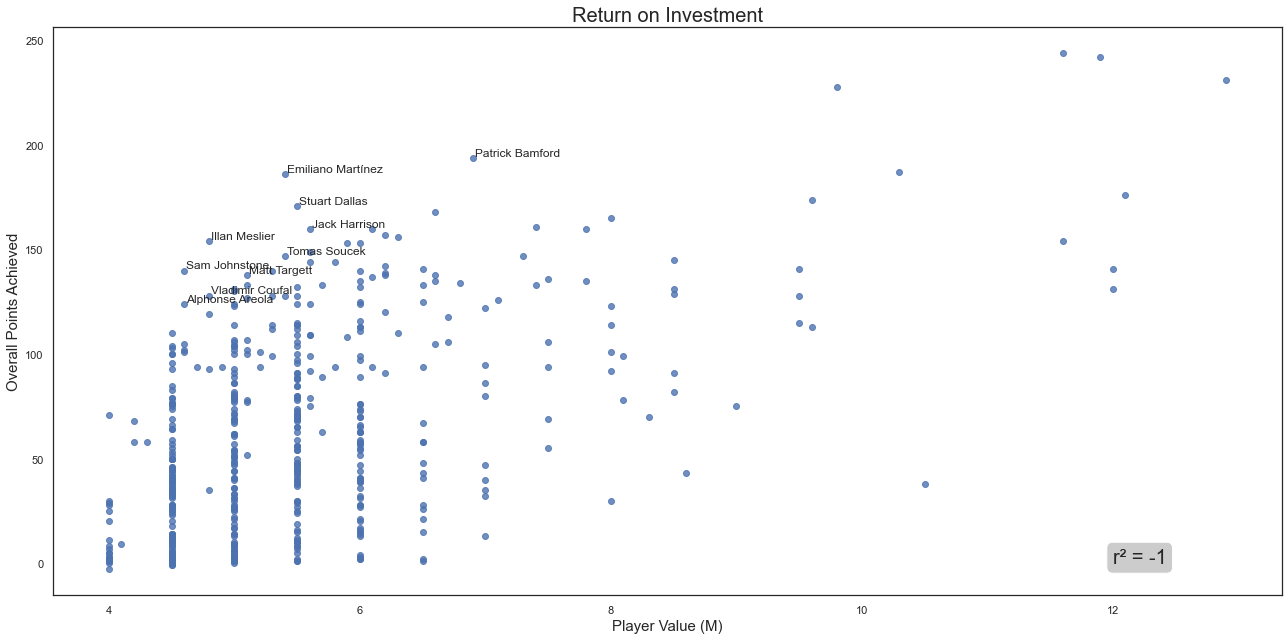

In [11]:
from sklearn.metrics import r2_score
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
    player_value_points['value'], player_value_points['total_points'], ax=ax, ci=False, marker='o',fit_reg=False
).annotate('r² = ' + str(round(r2_score(player_value_points['total_points'], player_value_points['value']))),
           xy=(12,0), fontsize = 20, bbox = bbox)
ax.set_title('Return on Investment', fontsize = 20)
ax.set_xlabel('Player Value (M)', fontsize = 15)
ax.set_ylabel('Overall Points Achieved', fontsize = 15)

for row in player_value_points.head(10).iterrows():
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["value"], r["total_points"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize=12)
    
fig.tight_layout()

We can see that the top 10 players based on ROI all cost 7M or less. Picking up players based on ROI can help us free up some of our budget to pick up top performers while also maximising points. 

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

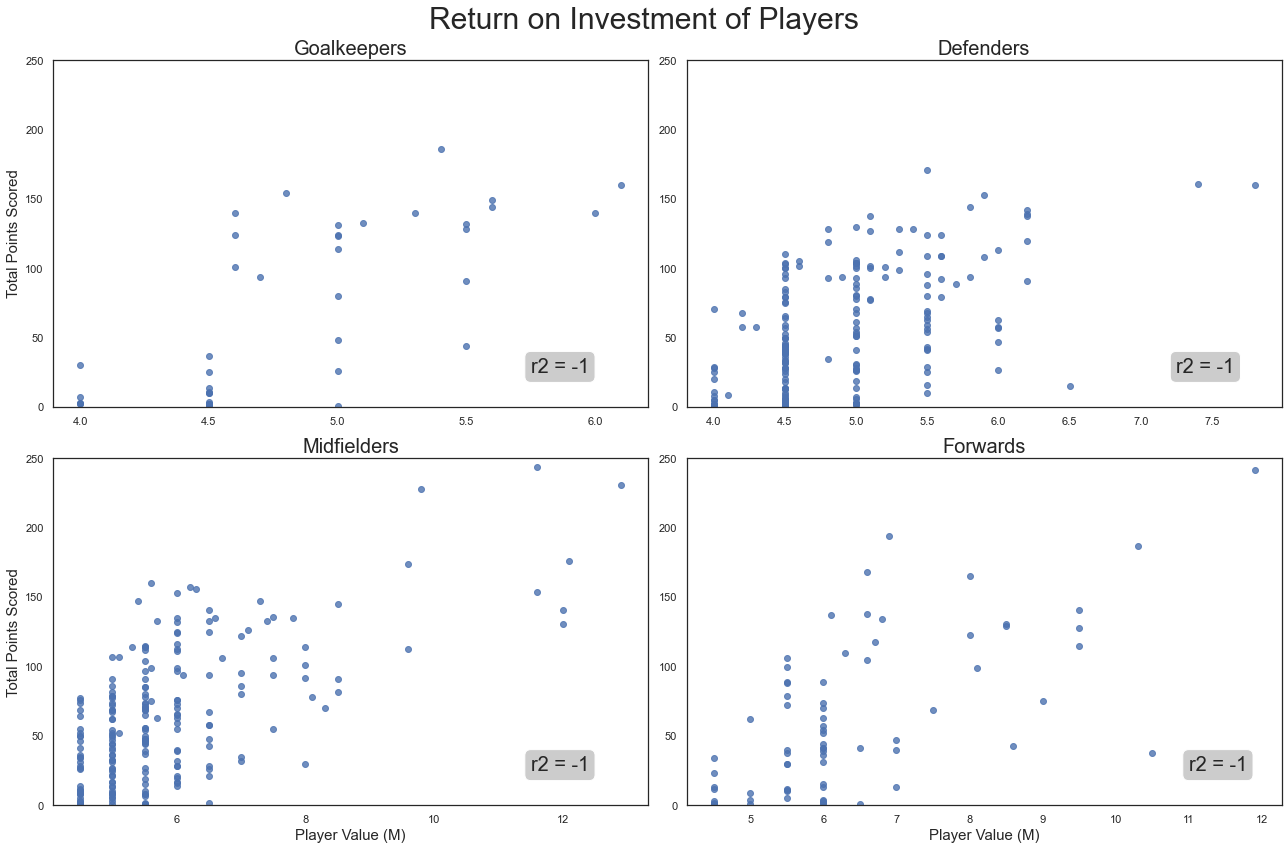

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

plt.suptitle('Return on Investment of Players', fontsize=30)
axs[0, 0].set_title('Goalkeepers', fontsize = 20)
axs[0, 1].set_title('Defenders', fontsize = 20)
axs[1, 0].set_title('Midfielders', fontsize = 20)
axs[1, 1].set_title('Forwards', fontsize = 20)

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
    player_value_points.groupby('position').get_group('GK')['value'], 
    player_value_points.groupby('position').get_group('GK')['total_points'], ax=axs[0,0], ci=False, marker='o',fit_reg=False
).annotate('r2 = ' + str(round(r2_score(player_value_points.groupby('position').get_group('GK')['total_points'], 
                                        player_value_points.groupby('position').get_group('GK')['value']))),
           xy=(5.75,25), fontsize = 20, bbox = bbox)

sns.regplot(
    player_value_points.groupby('position').get_group('DEF')['value'], 
    player_value_points.groupby('position').get_group('DEF')['total_points'], ax=axs[0,1], ci=False, marker='o',fit_reg=False
).annotate('r2 = ' + str(round(r2_score(player_value_points.groupby('position').get_group('DEF')['total_points'], 
                                        player_value_points.groupby('position').get_group('DEF')['value']))),
           xy=(7.25,25), fontsize = 20, bbox = bbox)

sns.regplot(
    player_value_points.groupby('position').get_group('MID')['value'], 
    player_value_points.groupby('position').get_group('MID')['total_points'], ax=axs[1,0], ci=False, marker='o',fit_reg=False
).annotate('r2 = ' + str(round(r2_score(player_value_points.groupby('position').get_group('MID')['total_points'], 
                                        player_value_points.groupby('position').get_group('MID')['value']))),
           xy=(11.5,25), fontsize = 20, bbox = bbox)

sns.regplot(
    player_value_points.groupby('position').get_group('FWD')['value'], 
    player_value_points.groupby('position').get_group('FWD')['total_points'], ax=axs[1,1], ci=False, marker='o',fit_reg=False
).annotate('r2 = ' + str(round(r2_score(player_value_points.groupby('position').get_group('FWD')['total_points'], 
                                        player_value_points.groupby('position').get_group('FWD')['value']))),
           xy=(11,25), fontsize = 20, bbox = bbox)

axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Total Points Scored', fontsize = 15)
axs[0, 0].set_ylim([0,250])

axs[0, 1].set_xlabel('')
axs[0, 1].set_ylabel('')
axs[0, 1].set_ylim([0,250])

axs[1, 0].set_xlabel('Player Value (M)', fontsize = 15)
axs[1, 0].set_ylabel('Total Points Scored', fontsize = 15)
axs[1, 0].set_ylim([0,250])

axs[1, 1].set_xlabel('Player Value (M)', fontsize = 15)
axs[1, 1].set_ylabel('')
axs[1, 1].set_ylim([0,250])

fig.tight_layout()

The top 3 players based on ROI in each position are shown here alongside the scatterplots. It is interesting that within these marked players we have the highest scoring goalkeeper, defender and the 2nd highest scoring foward. This shows ROI can be a good metric to use when selecting players.

We can look into the relationships between the three variables; ROI, Total Points and Value

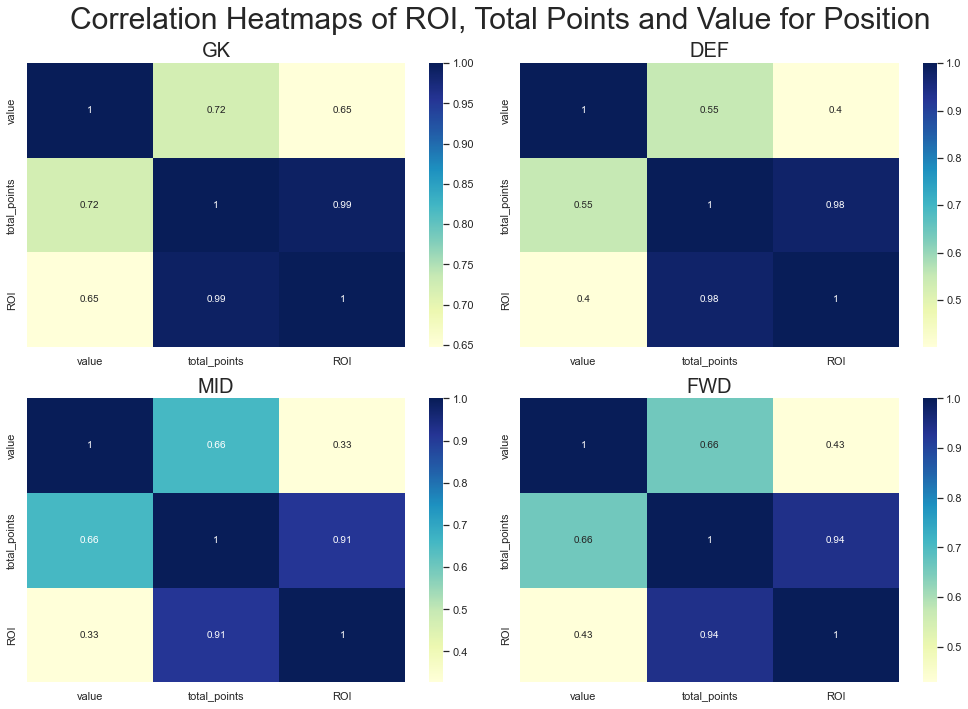

In [13]:
fig, axs = plt.subplots(2,2, figsize=(14, 10))

plt.suptitle('Correlation Heatmaps of ROI, Total Points and Value for Position', fontsize=30)

sns.heatmap(player_value_points.groupby('position').get_group('GK').corr(method='pearson'),
            cmap="YlGnBu", ax=axs[0,0],
            annot=True).set_title("GK", fontsize=20)

sns.heatmap(player_value_points.groupby('position').get_group('DEF').corr(method='pearson'),
            cmap="YlGnBu",ax=axs[0,1],
            annot=True).set_title("DEF", fontsize=20)

sns.heatmap(player_value_points.groupby('position').get_group('MID').corr(method='pearson'),
            cmap="YlGnBu",ax=axs[1,0],
            annot=True).set_title("MID", fontsize=20)

sns.heatmap(player_value_points.groupby('position').get_group('FWD').corr(method='pearson'),
            cmap="YlGnBu",ax=axs[1,1],
            annot=True).set_title("FWD", fontsize=20)

fig.tight_layout()

These heatmaps show us that ROI is a good metric to use when selecting goalkeepers and defenders as there is a strong relationship between ROI and total points, however this relationship is not as strong in midfielders and forwards. 

## ROI vs Total Points

We can look at the top players ranked by both ROI and total points.

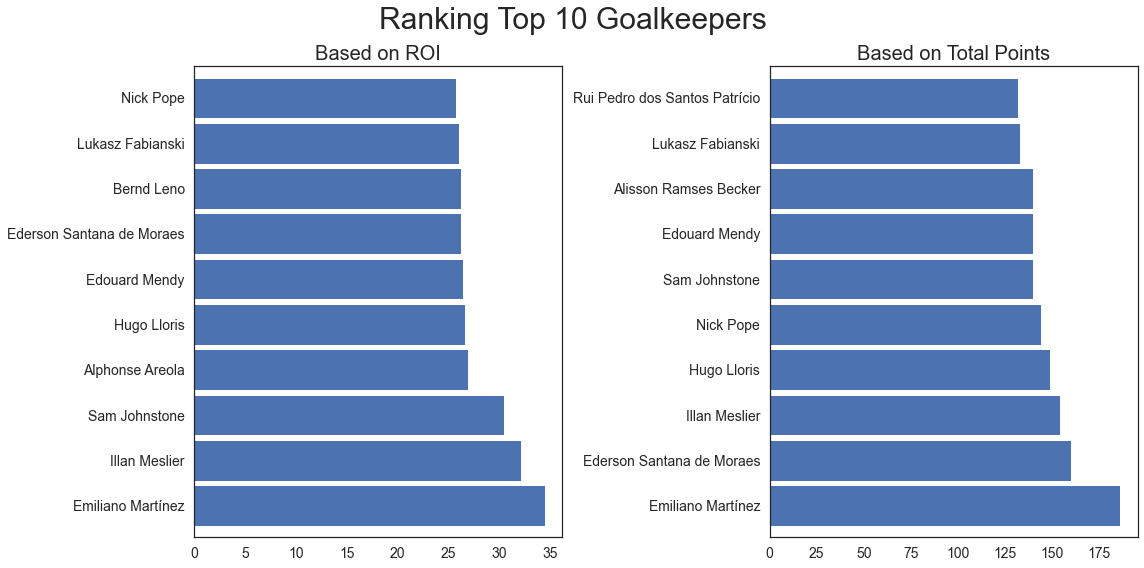

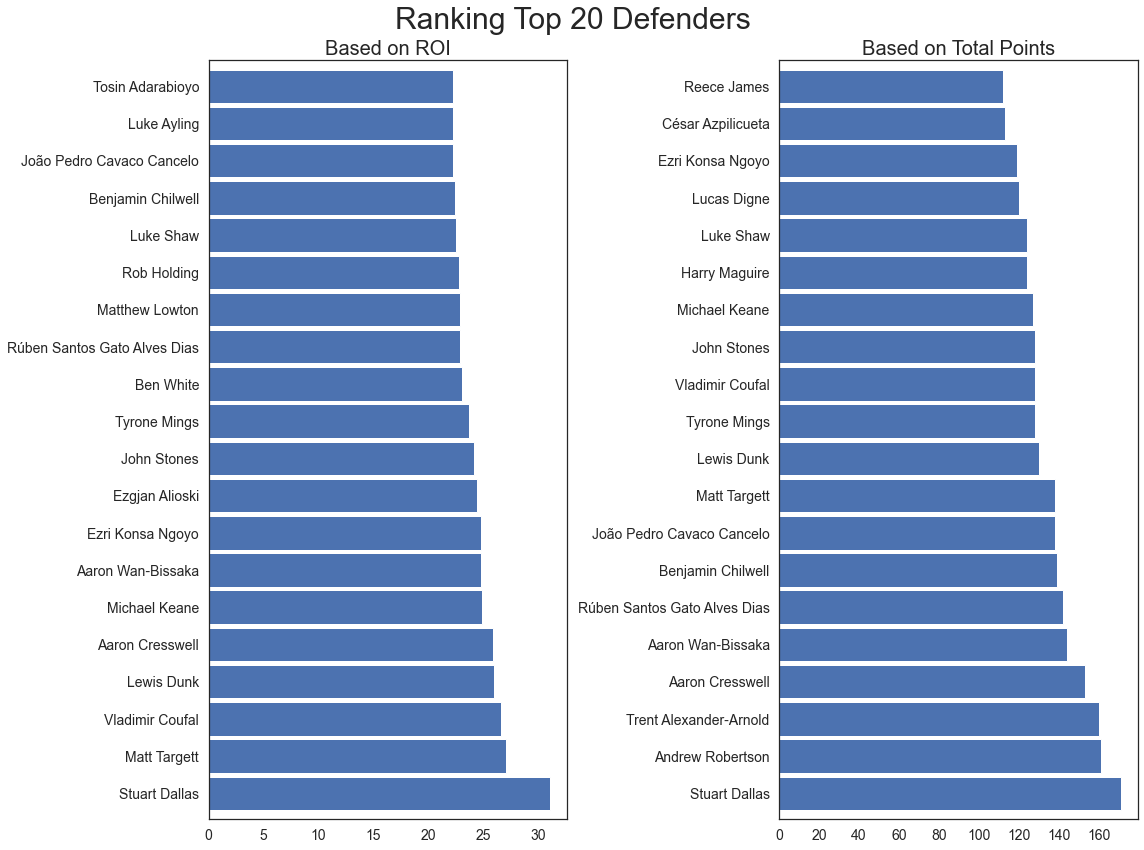

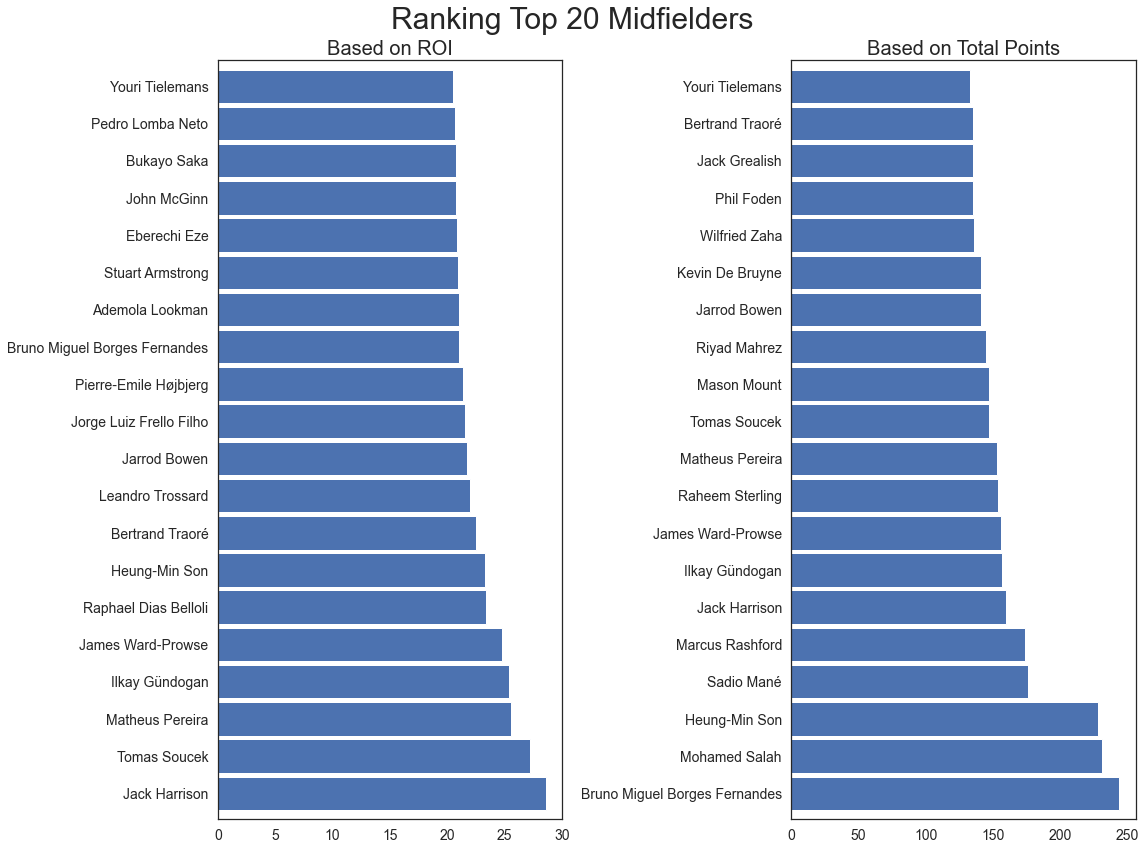

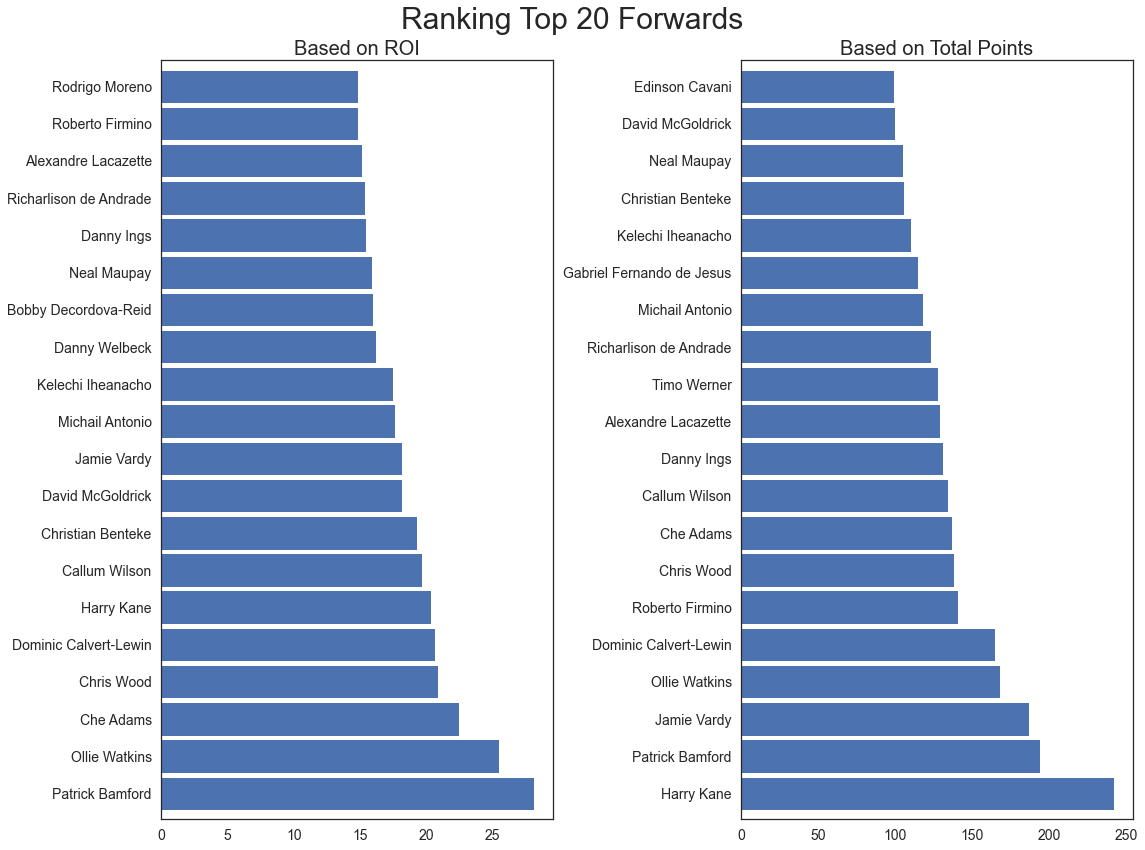

In [14]:
#Players ranked by total points 
player_value_points_rank = player_value_points.sort_values(by='total_points', ascending=False)

fig, (ax, bx) = plt.subplots(figsize=(32, 8), ncols=2)
plt.suptitle('Ranking Top 10 Goalkeepers', fontsize=30)

player_value_points.groupby('position').get_group('GK').head(10).plot( kind='barh', ax=ax
                                                                        , y=["ROI"], legend=0
                                                                        , stacked=False
                                                                        , colormap=ListedColormap(sns.color_palette())
                                                                        , figsize=(16,8)
                                                                        , xlabel= ''
                                                                        , fontsize = 14
                                                                        , width=.9).set_title("Based on ROI"
                                                                                              , fontsize = 20)

player_value_points_rank.groupby('position').get_group('GK').head(10).plot( kind='barh', ax=bx
                                                                            , y=["total_points"], legend=0
                                                                            , stacked=False
                                                                            , colormap=ListedColormap(sns.color_palette())
                                                                            , figsize=(16,8)
                                                                            , xlabel= ''
                                                                            , fontsize = 14
                                                                            , width=.9).set_title("Based on Total Points"
                                                                                              , fontsize = 20)

fig.tight_layout()

fig, (ax, bx) = plt.subplots(figsize=(32, 12), ncols=2)
plt.suptitle('Ranking Top 20 Defenders', fontsize=30)

player_value_points.groupby('position').get_group('DEF').head(20).plot( kind='barh', ax=ax
                                                                        , y=["ROI"], legend=0
                                                                        , stacked=False
                                                                        , colormap=ListedColormap(sns.color_palette())
                                                                        , figsize=(16,12)
                                                                        , xlabel= ''
                                                                        , fontsize = 14
                                                                        , width=.9).set_title("Based on ROI"
                                                                                              , fontsize = 20)


player_value_points_rank.groupby('position').get_group('DEF').head(20).plot( kind='barh', ax=bx
                                                                            , y=["total_points"], legend=0
                                                                            , stacked=False
                                                                            , colormap=ListedColormap(sns.color_palette())
                                                                            , figsize=(16,12)
                                                                            , xlabel= ''
                                                                            , fontsize = 14
                                                                            , width=.9).set_title("Based on Total Points"
                                                                                              , fontsize = 20)

fig.tight_layout()

fig, (ax, bx) = plt.subplots(figsize=(32, 12), ncols=2)
plt.suptitle('Ranking Top 20 Midfielders', fontsize=30)

player_value_points.groupby('position').get_group('MID').head(20).plot( kind='barh', ax=ax
                                                                        , y=["ROI"], legend=0
                                                                        , stacked=False
                                                                        , colormap=ListedColormap(sns.color_palette())
                                                                        , figsize=(16,12)
                                                                        , xlabel= ''
                                                                        , fontsize = 14
                                                                        , width=.9).set_title("Based on ROI"
                                                                                              , fontsize = 20)


player_value_points_rank.groupby('position').get_group('MID').head(20).plot( kind='barh', ax=bx
                                                                            , y=["total_points"], legend=0
                                                                            , stacked=False
                                                                            , colormap=ListedColormap(sns.color_palette())
                                                                            , figsize=(16,12)
                                                                            , xlabel= ''
                                                                            , fontsize = 14
                                                                            , width=.9).set_title("Based on Total Points"
                                                                                              , fontsize = 20)

fig.tight_layout()

fig, (ax, bx) = plt.subplots(figsize=(32, 12), ncols=2)
plt.suptitle('Ranking Top 20 Forwards', fontsize=30)

player_value_points.groupby('position').get_group('FWD').head(20).plot( kind='barh', ax=ax
                                                                        , y=["ROI"], legend=0
                                                                        , stacked=False
                                                                        , colormap=ListedColormap(sns.color_palette())
                                                                        , figsize=(16,12)
                                                                        , xlabel= ''
                                                                        , fontsize = 14
                                                                        , width=.9).set_title("Based on ROI"
                                                                                              , fontsize = 20)


player_value_points_rank.groupby('position').get_group('FWD').head(20).plot( kind='barh', ax=bx
                                                                            ,y=["total_points"], legend=0
                                                                            , stacked=False
                                                                            , colormap=ListedColormap(sns.color_palette())
                                                                            , figsize=(16,12)
                                                                            , xlabel= ''
                                                                            , fontsize = 14
                                                                            , width=.9).set_title("Based on Total Points"
                                                                                              , fontsize = 20)

fig.tight_layout()

# Top Prices vs ROI

Best 15 players based on ROI vs Most expensive 15 players.

In [15]:
value_gk = player_value_points.groupby('position').get_group('GK').sort_values(by='value', ascending=False).head(2)
value_def = player_value_points.groupby('position').get_group('DEF').sort_values(by='value', ascending=False).head(6)
value_def = value_def[value_def.index != 'Virgil van Dijk'] #Spent most of the season injured
value_mid = player_value_points.groupby('position').get_group('MID').sort_values(by='value', ascending=False).head(5)
value_fwd = player_value_points.groupby('position').get_group('FWD').sort_values(by='value', ascending=False).head(4)
value_fwd = value_fwd[value_fwd.index != 'Sergio Agüero'] #Spent most of the season injured

value_merged = value_gk.append(value_def).append(value_mid).append(value_fwd)
print(value_merged[['position','team','value']].to_latex())

\begin{tabular}{lllr}
\toprule
{} & position &       team &  value \\
name                          &          &            &        \\
\midrule
Ederson Santana de Moraes     &       GK &   Man City &    6.1 \\
Alisson Ramses Becker         &       GK &  Liverpool &    6.0 \\
Trent Alexander-Arnold        &      DEF &  Liverpool &    7.8 \\
Andrew Robertson              &      DEF &  Liverpool &    7.4 \\
Benjamin Chilwell             &      DEF &    Chelsea &    6.2 \\
Lucas Digne                   &      DEF &    Everton &    6.2 \\
Kyle Walker                   &      DEF &   Man City &    6.2 \\
Mohamed Salah                 &      MID &  Liverpool &   12.9 \\
Sadio Mané                    &      MID &  Liverpool &   12.1 \\
Kevin De Bruyne               &      MID &   Man City &   12.0 \\
Pierre-Emerick Aubameyang     &      MID &    Arsenal &   12.0 \\
Bruno Miguel Borges Fernandes &      MID &    Man Utd &   11.6 \\
Harry Kane                    &      FWD &      Spurs &   11.9 

C:\Users\phili\AppData\Local\Temp\ipykernel_16012\52750676.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_merged = value_gk.append(value_def).append(value_mid).append(value_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\52750676.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_merged = value_gk.append(value_def).append(value_mid).append(value_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\52750676.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_merged = value_gk.append(value_def).append(value_mid).append(value_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\52750676.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation

In [16]:
roi_gk = player_value_points.groupby('position').get_group('GK').sort_values(by='ROI', ascending=False).head(2)
roi_def = player_value_points.groupby('position').get_group('DEF').sort_values(by='ROI', ascending=False).head(5)
roi_mid = player_value_points.groupby('position').get_group('MID').sort_values(by='ROI', ascending=False).head(5)
roi_fwd = player_value_points.groupby('position').get_group('FWD').sort_values(by='ROI', ascending=False).head(3)

roi_merged = roi_gk.append(roi_def).append(roi_mid).append(roi_fwd)
print(roi_merged[['position','team','value']].to_latex())

\begin{tabular}{lllr}
\toprule
{} & position &         team &  value \\
name              &          &              &        \\
\midrule
Emiliano Martínez &       GK &  Aston Villa &    5.4 \\
Illan Meslier     &       GK &        Leeds &    4.8 \\
Stuart Dallas     &      DEF &        Leeds &    5.5 \\
Matt Targett      &      DEF &  Aston Villa &    5.1 \\
Vladimir Coufal   &      DEF &     West Ham &    4.8 \\
Lewis Dunk        &      DEF &     Brighton &    5.0 \\
Aaron Cresswell   &      DEF &     West Ham &    5.9 \\
Jack Harrison     &      MID &        Leeds &    5.6 \\
Tomas Soucek      &      MID &     West Ham &    5.4 \\
Matheus Pereira   &      MID &    West Brom &    6.0 \\
Ilkay Gündogan    &      MID &     Man City &    6.2 \\
James Ward-Prowse &      MID &  Southampton &    6.3 \\
Patrick Bamford   &      FWD &        Leeds &    6.9 \\
Ollie Watkins     &      FWD &  Aston Villa &    6.6 \\
Che Adams         &      FWD &  Southampton &    6.1 \\
\bottomrule
\end{tabula

C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3652651794.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roi_merged = roi_gk.append(roi_def).append(roi_mid).append(roi_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3652651794.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roi_merged = roi_gk.append(roi_def).append(roi_mid).append(roi_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3652651794.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roi_merged = roi_gk.append(roi_def).append(roi_mid).append(roi_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3652651794.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` 

In [17]:
best_gk = player_value_points.groupby('position').get_group('GK').sort_values(by='total_points', ascending=False).head(2)
best_def = player_value_points.groupby('position').get_group('DEF').sort_values(by='total_points', ascending=False).head(5)
best_mid = player_value_points.groupby('position').get_group('MID').sort_values(by='total_points', ascending=False).head(5)
best_fwd = player_value_points.groupby('position').get_group('FWD').sort_values(by='total_points', ascending=False).head(3)

best_merged = best_gk.append(best_def).append(best_mid).append(best_fwd)
print(best_merged[['position','team','value']].to_latex())

\begin{tabular}{lllr}
\toprule
{} & position &         team &  value \\
name                          &          &              &        \\
\midrule
Emiliano Martínez             &       GK &  Aston Villa &    5.4 \\
Ederson Santana de Moraes     &       GK &     Man City &    6.1 \\
Stuart Dallas                 &      DEF &        Leeds &    5.5 \\
Andrew Robertson              &      DEF &    Liverpool &    7.4 \\
Trent Alexander-Arnold        &      DEF &    Liverpool &    7.8 \\
Aaron Cresswell               &      DEF &     West Ham &    5.9 \\
Aaron Wan-Bissaka             &      DEF &      Man Utd &    5.8 \\
Bruno Miguel Borges Fernandes &      MID &      Man Utd &   11.6 \\
Mohamed Salah                 &      MID &    Liverpool &   12.9 \\
Heung-Min Son                 &      MID &        Spurs &    9.8 \\
Sadio Mané                    &      MID &    Liverpool &   12.1 \\
Marcus Rashford               &      MID &      Man Utd &    9.6 \\
Harry Kane                    &    

C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3196614843.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_merged = best_gk.append(best_def).append(best_mid).append(best_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3196614843.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_merged = best_gk.append(best_def).append(best_mid).append(best_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3196614843.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_merged = best_gk.append(best_def).append(best_mid).append(best_fwd)
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3196614843.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `St

In [18]:
roi_total_points = roi_merged['total_points'].sum()
roi_total_points

value_merged_points = value_merged['total_points'].sum()
value_merged_points

best_merged_points = best_merged['total_points'].sum()
best_merged_points

2811.0

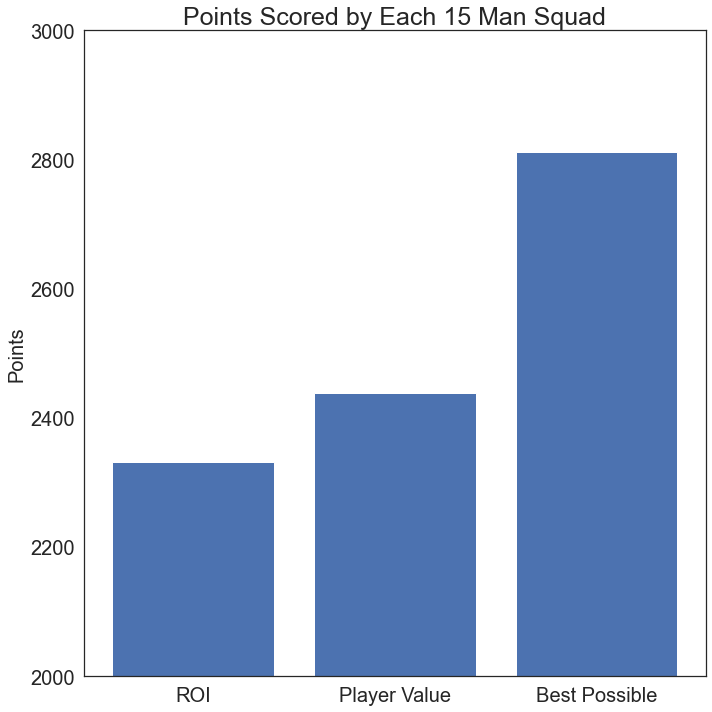

In [19]:
fig,ax = plt.subplots(figsize=(10, 10))

xg1 = ["ROI", "Player Value","Best Possible"]
yg1 = [roi_total_points, value_merged_points,best_merged_points]
ax.bar(xg1,yg1)
ax.set_title('Points Scored by Each 15 Man Squad', fontsize=25)
ax.tick_params(labelsize=20)
ax.set_ylim([2000,3000])
ax.set_ylabel('Points', fontsize = 20)

fig.tight_layout()
fig.savefig('roiVvalueVbest.png')

Players of higher value score more points than the best players based on ROI.

# Distribution of Top Player's Points

Look into each players perfromances over each gameweek and investigate their points scored.

In [20]:
top_GKs = player_value_points_rank.groupby('position').get_group('GK').head(10).drop(['total_points', 'value','ROI'], axis = 1).reset_index()
gks = {}
top_DEFs = player_value_points_rank.groupby('position').get_group('DEF').head(20).drop(['total_points', 'value','ROI'], axis = 1).reset_index()
defs = {}
top_MIDs = player_value_points_rank.groupby('position').get_group('MID').head(20).drop(['total_points', 'value','ROI'], axis = 1).reset_index()
mids = {}
top_FWDs = player_value_points_rank.groupby('position').get_group('FWD').head(20).drop(['total_points', 'value','ROI'], axis = 1).reset_index()
fwds = {}

l = top_GKs['name'].tolist()
df = (gws.loc[gws['name'].isin(l)])
df_new = df[['name', 'total_points']]
df_new = df_new.reset_index()
df_new = df_new.drop(['gw'], axis=1)
for x in l:
    test = df_new.loc[df_new['name'] == (x)]['total_points']
    string = ''
    for n in range(1,80,2):
        string +=  (str(test).split()[n].replace('[','')
                    .replace(']','').replace(',','').replace('Name: total_points, dtype: float64','')
                    .replace('total_points','').replace('float64','') + ' ')
    gks[x] = string
    gks[x] = gks[x].split(' ')
    while '' in gks[x]: gks[x].remove('')  
    while 'NaN' in gks[x]: gks[x].remove('NaN')  
    
l = top_MIDs['name'].tolist()
df = (gws.loc[gws['name'].isin(l)])
df_new = df[['name', 'total_points']]
df_new = df_new.reset_index()
df_new = df_new.drop(['gw'], axis=1)
for x in l:
    test = df_new.loc[df_new['name'] == (x)]['total_points']
    string = ''
    for n in range(1,80,2):
        string +=  (str(test).split()[n].replace('[','')
                    .replace(']','').replace(',','').replace('Name: total_points, dtype: float64','')
                    .replace('total_points','').replace('float64','') + ' ')
    mids[x] = string
    mids[x] = mids[x].split(' ')
    while '' in mids[x]: mids[x].remove('')  
    while 'NaN' in mids[x]: mids[x].remove('NaN')  
    
l = top_DEFs['name'].tolist()
df = (gws.loc[gws['name'].isin(l)])
df_new = df[['name', 'total_points']]
df_new = df_new.reset_index()
df_new = df_new.drop(['gw'], axis=1)
for x in l:
    test = df_new.loc[df_new['name'] == (x)]['total_points']
    string = ''
    for n in range(1,80,2):
        string +=  (str(test).split()[n].replace('[','')
                    .replace(']','').replace(',','').replace('Name: total_points, dtype: float64','')
                    .replace('total_points','').replace('float64','') + ' ')
    defs[x] = string
    defs[x] = defs[x].split(' ')
    while '' in defs[x]: defs[x].remove('')  
    while 'NaN' in defs[x]: defs[x].remove('NaN')  

l = top_FWDs['name'].tolist()
df = (gws.loc[gws['name'].isin(l)])
df_new = df[['name', 'total_points']]
df_new = df_new.reset_index()
df_new = df_new.drop(['gw'], axis=1)
for x in l:
    test = df_new.loc[df_new['name'] == (x)]['total_points']
    string = ''
    for n in range(1,80,2):
        string +=  (str(test).split()[n].replace('[','')
                    .replace(']','').replace(',','').replace('Name: total_points, dtype: float64','')
                    .replace('total_points','').replace('float64','') + ' ')
    fwds[x] = string
    fwds[x] = fwds[x].split(' ')
    while '' in fwds[x]: fwds[x].remove('')  
    while 'NaN' in fwds[x]: fwds[x].remove('NaN')  
    
top_GKs = pd.DataFrame.from_dict(gks, orient='index')
top_DEFs = pd.DataFrame.from_dict(defs, orient='index')
top_MIDs = pd.DataFrame.from_dict(mids, orient='index')
top_FWDs = pd.DataFrame.from_dict(fwds, orient='index')

cols = top_GKs.columns[top_GKs.dtypes.eq('object')]
top_GKs[cols] = top_GKs[cols].apply(pd.to_numeric, errors='coerce')
top_GKs = top_GKs.T

cols = top_DEFs.columns[top_DEFs.dtypes.eq('object')]
top_DEFs[cols] = top_DEFs[cols].apply(pd.to_numeric, errors='coerce')
top_DEFs = top_DEFs.T

cols = top_MIDs.columns[top_MIDs.dtypes.eq('object')]
top_MIDs[cols] = top_MIDs[cols].apply(pd.to_numeric, errors='coerce')
top_MIDs = top_MIDs.T

cols = top_FWDs.columns[top_FWDs.dtypes.eq('object')]
top_FWDs[cols] = top_FWDs[cols].apply(pd.to_numeric, errors='coerce')
top_FWDs = top_FWDs.T

For each boxplot the highest scoring player is at the top and they are ranked in descending order.

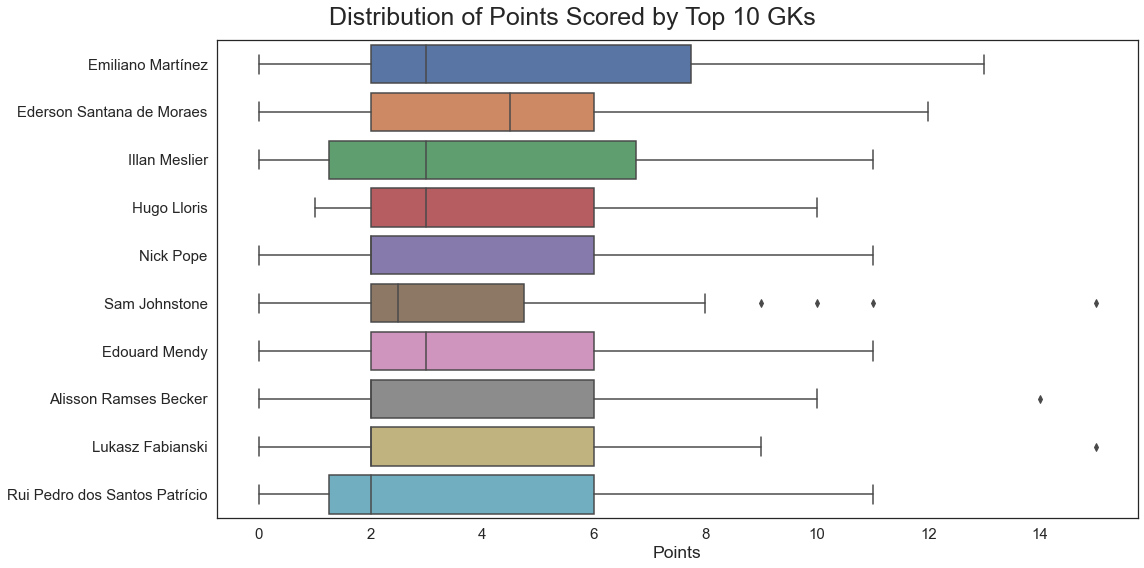

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle('Distribution of Points Scored by Top 10 GKs', fontsize=25)
sns.boxplot(data=top_GKs, orient= 'h')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Points', fontsize = 17.5)
fig.tight_layout()

Emiliano Martinez has the biggest range of points however his lower quartile is small and his upper quartile is quite large, explaining why he was the highest scoring goalkeeper. An interesting one is Sam Johnstone who has a lot of outliers in the high point range.

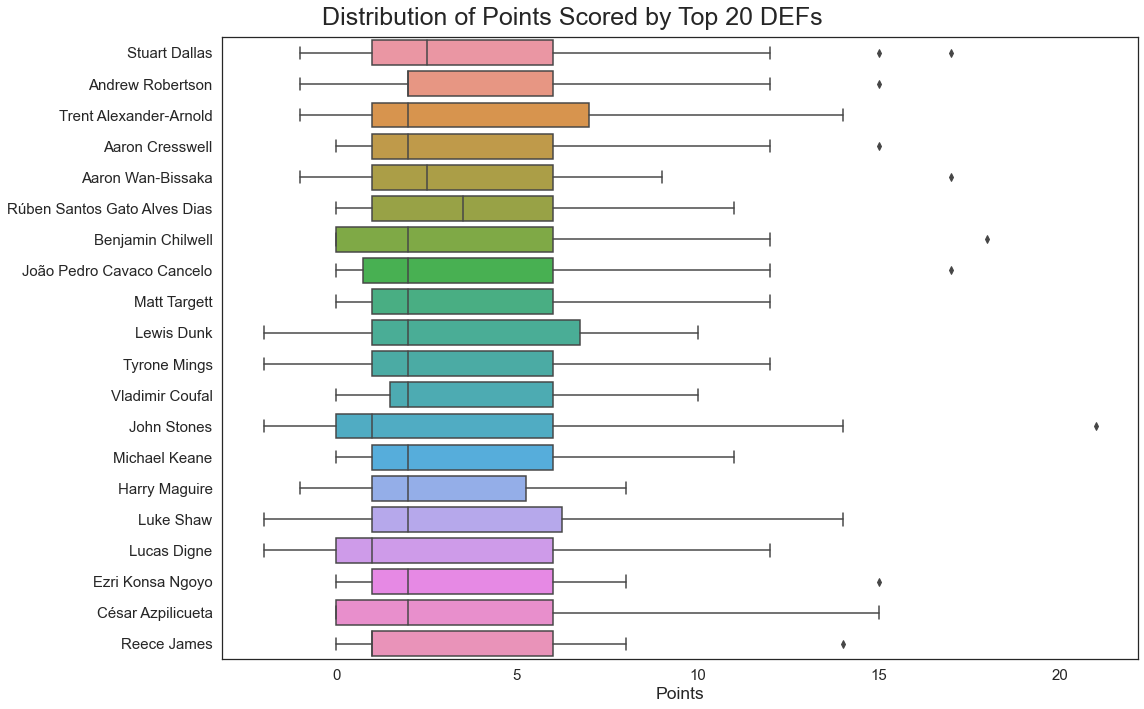

In [22]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.suptitle('Distribution of Points Scored by Top 20 DEFs', fontsize=25)
sns.boxplot(data=top_DEFs , orient= 'h')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Points', fontsize = 17.5)
fig.tight_layout()

The top scoring defender Stuart Dallas has the 2nd highest median points with a much larger upper quartile than lower quartile, aswell as outliers in which he scored very high points. An interesting one is Andrew Robertson as he has no lower quartile showing most of his performances are within the upper quartile of 2-7 points per game.

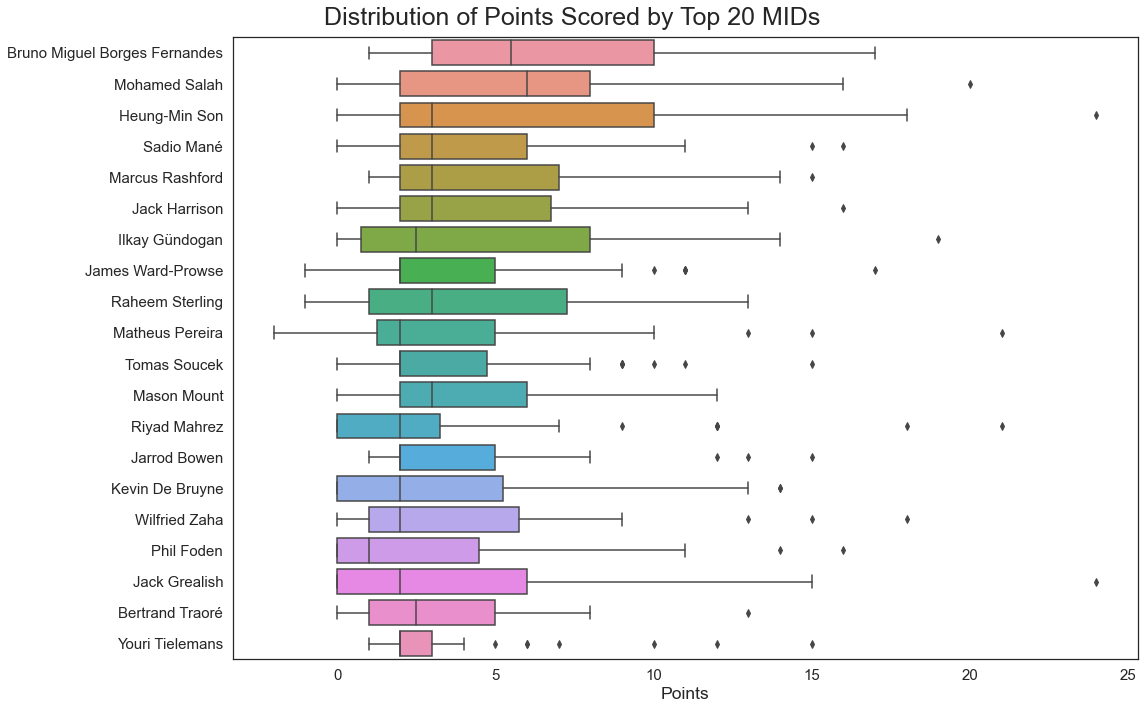

In [23]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.suptitle('Distribution of Points Scored by Top 20 MIDs', fontsize=25)
sns.boxplot(data=top_MIDs , orient= 'h')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Points', fontsize = 17.5)
fig.tight_layout()

This box plot shows a much larger amount of outliers than that of the goalkeeprs and defenders. Almost every midfielder has at least one outlier. The highest scoring player, Bruno Miguel Borges Fernandes, interestingly has no outliers showing consistency was the key to his high points which is also indicated by the large size of the lower and upper quartiles spanning from roughly 3-10 points per game. Another interesting one is Youri Tielemans who has very small inter-quartile ranges yet a lot of outliers.

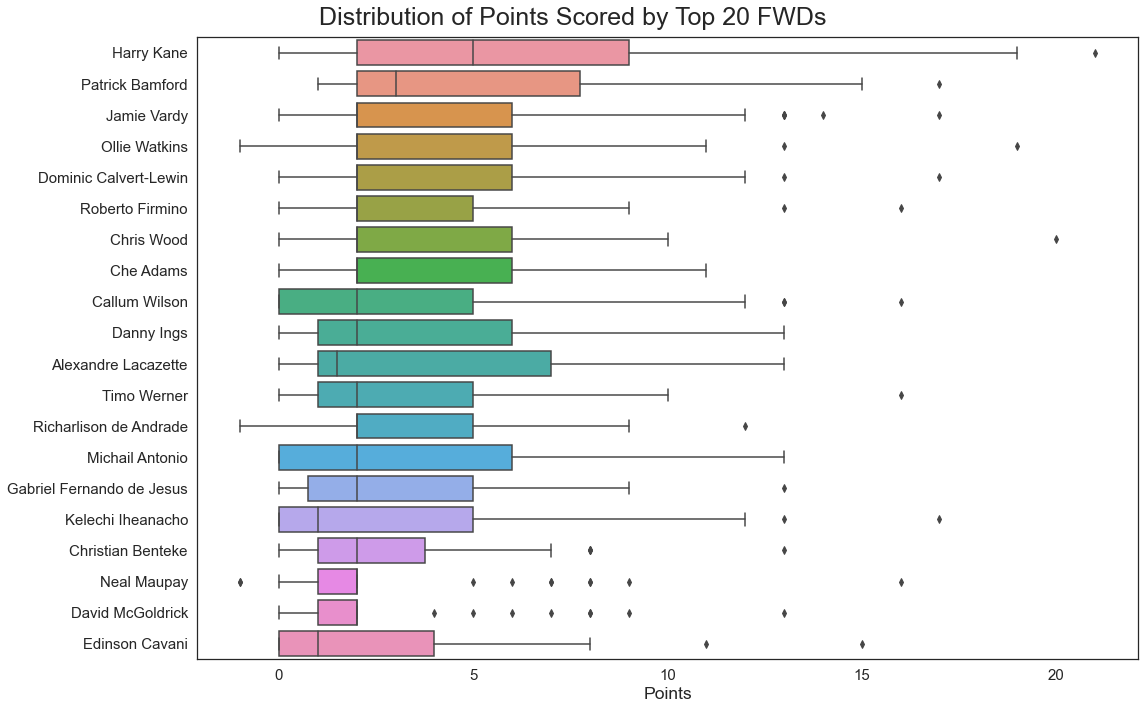

In [24]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.suptitle('Distribution of Points Scored by Top 20 FWDs', fontsize=25)
sns.boxplot(data=top_FWDs , orient= 'h')
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel('Points', fontsize = 17.5)
fig.tight_layout()

Harry Kane has a huge range of points, roughly 0-19, and an otlier, aswell as a high median and large inter-quartile ranges making it obviuos as to why he was the leading point scorer. Much like the midfielders, a lot of these players have outliers. Outliers seem to be a treand among forwards and midfielders. These boxplots help us identify players we could potetntially pick for the following season.

# Team Strength Level and Total Points

We can look into the relationships between teams strength levels and points scored.

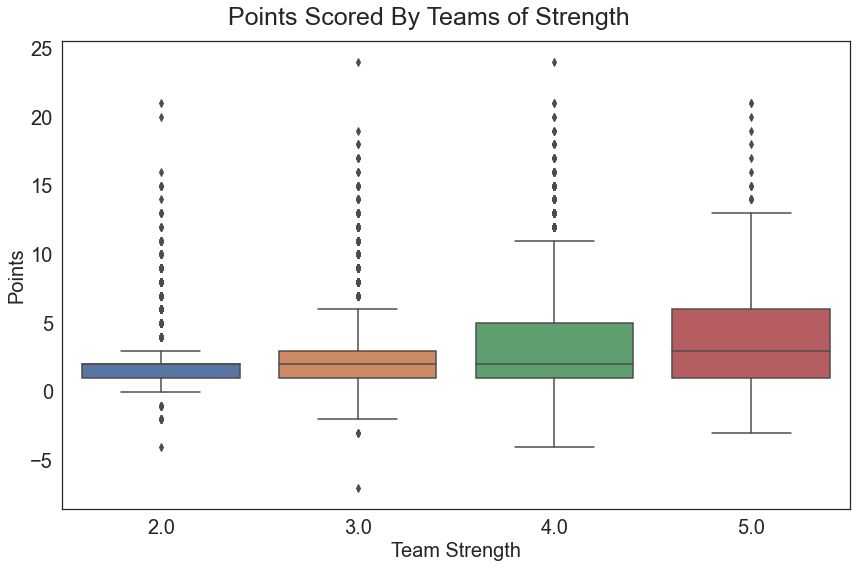

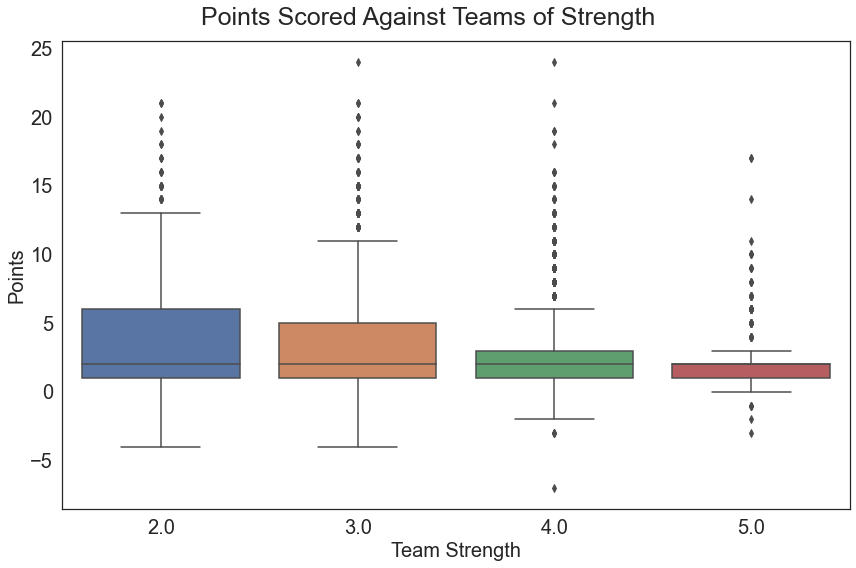

In [25]:
opponent_teams = teams
opponent_teams = opponent_teams.add_prefix('opponent_')
opponent_teams = opponent_teams.drop(['opponent_code','opponent_pulse_id', 'opponent_id'], axis=1)
opponent_teams = opponent_teams.reset_index()
opponent_teams.rename(columns = {'id':'opponent_team'}, inplace = True)
gws_teams = pd.merge(gws,opponent_teams, on=['opponent_team'], how='left')

team = teams
team = team.drop(['code','id'], axis=1)
team = team.reset_index()
team = team.drop(['id'], axis=1)
team.rename(columns = {'name':'team'}, inplace = True)
gws_teams = pd.merge(gws_teams,team, on=['team'], how='left')

teams_dist = gws_teams[['name', 'position', 'team','strength','opponent_name','opponent_strength', 'total_points', 'minutes']]
teams_dist = teams_dist[teams_dist.minutes != 0]
teams_dist = teams_dist[teams_dist.total_points != 'NaN']
teams_dist_opp = teams_dist
teams_dist_opp = teams_dist_opp

fig, ax = plt.subplots(figsize=(12, 8))
plt.suptitle('Points Scored By Teams of Strength', fontsize=25)
sns.boxplot(x="strength", y="total_points", data=teams_dist_opp)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Team Strength', fontsize = 20)
ax.set_ylabel('Points', fontsize = 20)
fig.tight_layout()
fig.savefig('pointsbystrength.png')

fig, ax = plt.subplots(figsize=(12, 8))
plt.suptitle('Points Scored Against Teams of Strength', fontsize=25)
sns.boxplot(x="opponent_strength", y="total_points", data=teams_dist_opp)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Team Strength', fontsize = 20)
ax.set_ylabel('Points', fontsize = 20)
fig.tight_layout()
fig.savefig('pointsbyOpstrength.png')

As expected, we can see a difference in the amount of points scored by/against each team depending on their strength levels. However, the gap between teams of strength level 3 and 4 looks much larger than the gap between the others. Interestingly, teams of strength level 3 and 4 have outliers above teams of strength level 2 in the points scored against chart.

In [26]:
print(team.set_index('team')[['strength']].to_latex())

\begin{tabular}{lr}
\toprule
{} &  strength \\
team           &           \\
\midrule
Arsenal        &         4 \\
Aston Villa    &         3 \\
Brighton       &         3 \\
Burnley        &         2 \\
Chelsea        &         4 \\
Crystal Palace &         3 \\
Everton        &         3 \\
Fulham         &         3 \\
Leicester      &         4 \\
Leeds          &         3 \\
Liverpool      &         4 \\
Man City       &         5 \\
Man Utd        &         4 \\
Newcastle      &         2 \\
Sheffield Utd  &         2 \\
Southampton    &         3 \\
Spurs          &         4 \\
West Brom      &         2 \\
West Ham       &         4 \\
Wolves         &         3 \\
\bottomrule
\end{tabular}



C:\Users\phili\AppData\Local\Temp\ipykernel_16012\2551715961.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(team.set_index('team')[['strength']].to_latex())


In [41]:
gks = player_value_points.groupby('position').get_group('GK').head(10)[['position','team']]


In [42]:
defs = player_value_points.groupby('position').get_group('DEF').head(20)[['position','team']]


In [43]:
mids = player_value_points.groupby('position').get_group('MID').head(20)[['position','team']]


In [44]:
fwds = player_value_points.groupby('position').get_group('FWD').head(15)[['position','team']]


In [47]:
print(gks.to_latex())
print(defs.to_latex())
print(mids.to_latex())
print(fwds.to_latex())

\begin{tabular}{lll}
\toprule
{} & position &         team \\
name                      &          &              \\
\midrule
Emiliano Martínez         &       GK &  Aston Villa \\
Illan Meslier             &       GK &        Leeds \\
Sam Johnstone             &       GK &    West Brom \\
Alphonse Areola           &       GK &       Fulham \\
Hugo Lloris               &       GK &        Spurs \\
Edouard Mendy             &       GK &      Chelsea \\
Ederson Santana de Moraes &       GK &     Man City \\
Bernd Leno                &       GK &      Arsenal \\
Lukasz Fabianski          &       GK &     West Ham \\
Nick Pope                 &       GK &      Burnley \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
{} & position &         team \\
name                         &          &              \\
\midrule
Stuart Dallas                &      DEF &        Leeds \\
Matt Targett                 &      DEF &  Aston Villa \\
Vladimir Coufal              &      DEF &     West H

C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3298186199.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(gks.to_latex())
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3298186199.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(defs.to_latex())
C:\Users\phili\AppData\Local\Temp\ipykernel_16012\3298186199.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting an